# This script processes the o2par results (tbb version of qmin) now with indices to point to the cloud and parallel tree

1. Compile o2par with:
```
make bin/o2par
```
2. Run the benchmarking script
```
cd scripts
python3 run_par_optim2.py
```
3. The output that we will process is `o2_partree_<hostname>.txt` that should be already saved in the `Results` folder.


In [1]:
import os
# get the hostname of the server
hostname = os.popen("hostname").read().strip()
# ensure the directory exists
os.makedirs(hostname, exist_ok=True)
# ensure the file with baseline results exists
o2_file = f'o2_partree_{hostname}.txt'
# if it is not in Results
if not os.path.exists(o2_file):
    # is the file already in the directory?
    assert os.path.exists(os.path.join(hostname, o2_file)), f'File {o2_file} not found: something went wrong with the baseline benchmark.'
# if it is in Results
else:
    # copy the file to the directory
    assert os.system(f'mv {o2_file} {hostname}/') == 0, f'Failed to move {o2_file} to {hostname}/'
# rename o2_file
o2_file = os.path.join(hostname, o2_file)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from statistics import mean
from common.utils import get_nprocs, get_best_level2

cloud_list = ['AlcoyH','ArzuaH','BrionFH','BrionUH']

# number of threads used in the execution
num_threads = get_nprocs()

def tokenize1(filename,noH=False):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                if noH:
                    name=tokens[2].split("/")[3][:-1]
                else:
                    name=tokens[2].split("/")[3]
                nth=int(tokens[6])
                if name not in experiment:
                    experiment[name]={}
            if 'Quadtree' in tokens:
                experiment[name][nth]=[float(tokens[5])]
            if "STAGE" in tokens:
                experiment[name][nth].append(float(tokens[5]))
            if 'Average:' in tokens:
                experiment[name][nth].append(float(tokens[1]))

    #print(experiment)

    results = {}

    for i in experiment:
        results[i]={}
        for j in experiment[i]:
            results[i][j]={}
            results[i][j]['qtree']=experiment[i][j][0]
            results[i][j]['stage1']=mean(experiment[i][j][1:16:3])
            results[i][j]['stage2']=mean(experiment[i][j][2:16:3])
            results[i][j]['stage3']=mean(experiment[i][j][3:16:3])
            results[i][j]['owm']=experiment[i][j][16]
            results[i][j]['total']=experiment[i][j][0]+experiment[i][j][16]
    return results

def tokenize2(filename,noH=False):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                if noH:
                    name=tokens[3].split("/")[3][:-1]
                else:
                    name=tokens[3].split("/")[3]
                nth=int(tokens[11])
                level=int(tokens[19])
                if name not in experiment:
                    experiment[name]={}
                if level not in experiment[name]:
                    experiment[name][level]={}
                if nth not in experiment[name][level]:
                    experiment[name][level][nth]=[]
            if "STAGE" in tokens:
                experiment[name][level][nth].append(float(tokens[5]))
            if 'Quadtree' in tokens:
                experiment[name][level][nth].append(float(tokens[5]))
            if 'Average' in tokens:
                experiment[name][level][nth].append(float(tokens[2]))

    #print(experiment)

    results = {}

    for i in experiment:
        results[i]={}
        for j in experiment[i]:
            results[i][j]={}
            for k in experiment[i][j]:
                results[i][j][k]={}
                results[i][j][k]['qtree']=experiment[i][j][k][15]
                results[i][j][k]['stage1']=mean(experiment[i][j][k][0:15:3])
                results[i][j][k]['stage2']=mean(experiment[i][j][k][1:15:3])
                results[i][j][k]['stage3']=mean(experiment[i][j][k][2:15:3])
                results[i][j][k]['owm']=experiment[i][j][k][16]
                results[i][j][k]['total']=experiment[i][j][k][15]+experiment[i][j][k][16]
    return results

res1=tokenize1(os.path.join(hostname, f'o1_qtree_{hostname}.txt'))
# res2=tokenize1("o2_parallel_coffee.txt",True) # optim2 without parallel tree construction
res2=tokenize2(os.path.join(hostname, f'o2_partree_{hostname}.txt'))  # optim2 with parallel tree construction


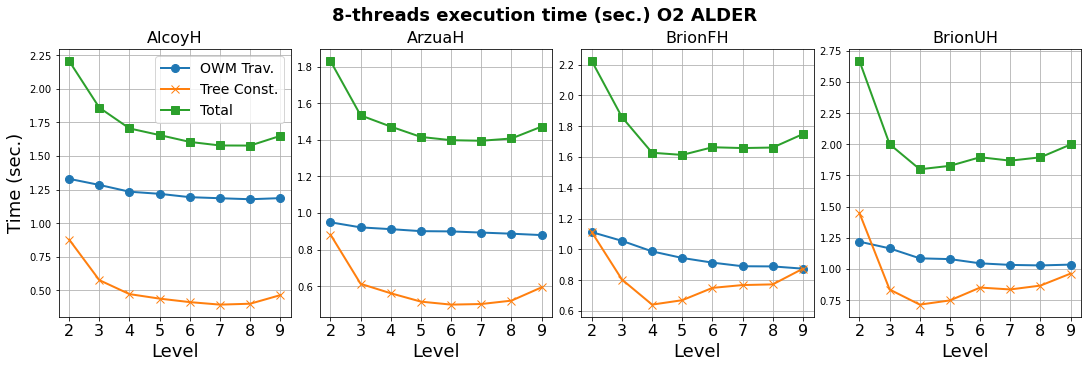

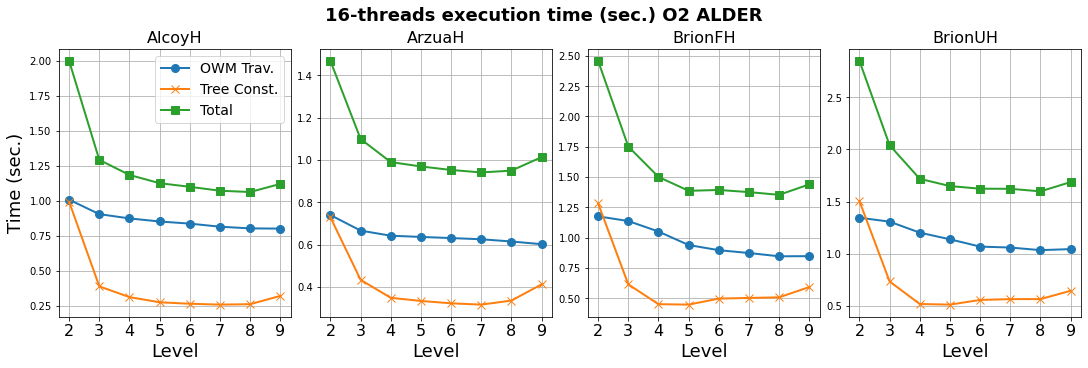

In [3]:
def plot_levels(nth,results):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM Trav.','Tree Const.','Total']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in enumerate(cloud_list):
        x=list(results[name].keys())
        axs[i].plot(np.array(x), np.array([results[name][j][nth]['owm'] for j in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][j][nth]['qtree'] for j in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][j][nth]['qtree']+results[name][j][nth]['owm'] for j in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Level', fontsize=xlabelfs)
        axs[i].set_xticks(x)
        axs[i].tick_params(axis='x', labelsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()
    if(nth==1):
        fig.suptitle('Execution time (sec.)',  fontweight='bold', fontsize=18)
    if(nth>1):
        fig.suptitle(f'{nth}-threads execution time (sec.) O2 {hostname.upper()}',  fontweight='bold', fontsize=18)

    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    pp = PdfPages(os.path.join(hostname, f'Optim2_{nth}coresExecTime-{hostname}.pdf'))
    pp.savefig(fig)
    pp.close()

# plot 8 and 16 if AlderLake
if hostname == 'alder':
    plot_levels(8, res2)
    plot_levels(16, res2)
else:
    plot_levels(num_threads[-1], res2)


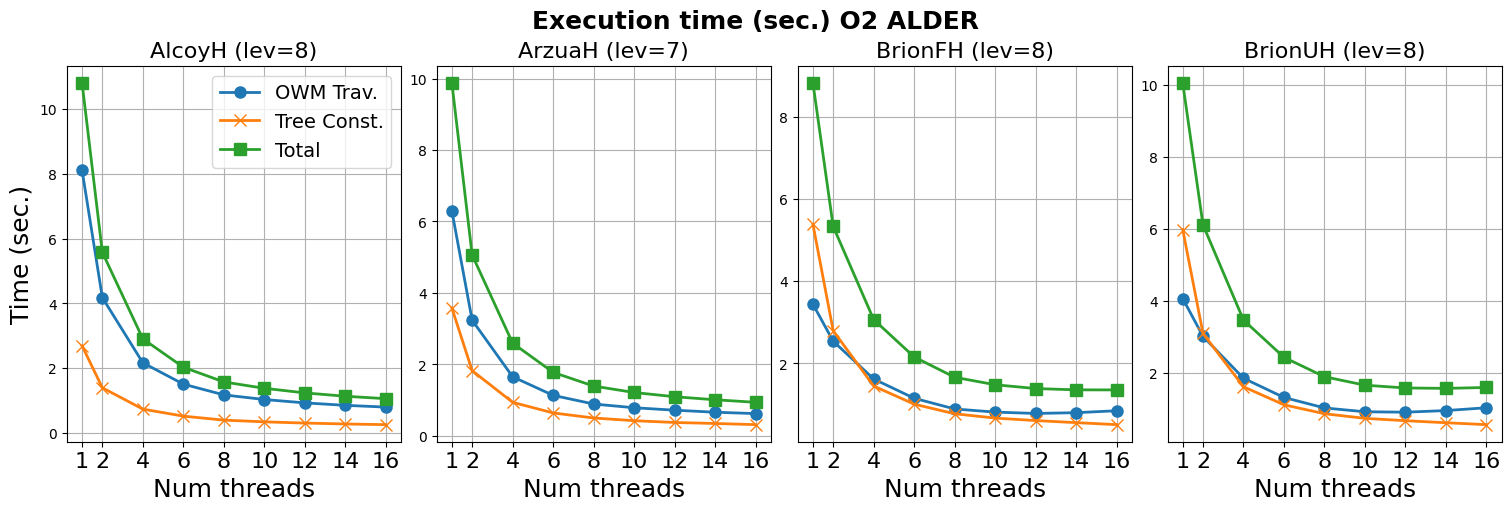

In [5]:
def plot_times_index(results, maxth=8):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM Trav.','Tree Const.','Total']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4), cloud_list):
        # select the best level for each experiment
        # bestlevel=min(results[name], key=lambda x: results[name][x][maxth]['total'])
        bestlevel = get_best_level2(results[name], maxth, 'total')
        x=list(results[name][bestlevel].keys())
        axs[i].plot(np.array(x), np.array([results[name][bestlevel][nth]['owm'] for nth in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][bestlevel][nth]['qtree'] for nth in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][bestlevel][nth]['total'] for nth in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name+ " (lev="+str(bestlevel)+")",fontsize=16)
        axs[i].set_xlabel('Num threads', fontsize=xlabelfs)
        axs[i].set_xticks(x)
        axs[i].tick_params(axis='x', labelsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle(f'Execution time (sec.) O2 {hostname.upper()}',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()

plot_times_index(, maxth=num_threads[-1])

# Compare OWM traversal improvement

In [6]:
def printowm(nth,res):#best level
    for i in res:
        bestlevel = get_best_level2(res[i], nth, 'total')
        print("Cloud {} has best level = {}.".format(i, bestlevel))
        print("Cloud {} has {}-cores OMP OWM-o1 quadtree time = {:.2f}.".format(i,nth, res1[i][nth]['owm']))    
        print("Cloud {} has {}-cores OWM-o2 partree time = {:.2f}. Speedup (o2 partree vs o1) = {:.2f}x.".format(i,nth,res[i][bestlevel][nth]['owm'], res1[i][nth]['owm']/res[i][bestlevel][nth]['owm'] ))    

#printowm(1,res2)
printowm(num_threads[-1],res2)

Cloud AlcoyH has best level = 8.
Cloud AlcoyH has 16-cores OMP OWM-o1 quadtree time = 0.81.
Cloud AlcoyH has 16-cores OWM-o2 partree time = 0.80. Speedup (o2 partree vs o1) = 1.01x.
Cloud ArzuaH has best level = 7.
Cloud ArzuaH has 16-cores OMP OWM-o1 quadtree time = 0.74.
Cloud ArzuaH has 16-cores OWM-o2 partree time = 0.63. Speedup (o2 partree vs o1) = 1.18x.
Cloud BrionFH has best level = 8.
Cloud BrionFH has 16-cores OMP OWM-o1 quadtree time = 2.05.
Cloud BrionFH has 16-cores OWM-o2 partree time = 0.85. Speedup (o2 partree vs o1) = 2.42x.
Cloud BrionUH has best level = 8.
Cloud BrionUH has 16-cores OMP OWM-o1 quadtree time = 2.46.
Cloud BrionUH has 16-cores OWM-o2 partree time = 1.03. Speedup (o2 partree vs o1) = 2.38x.


# Compare Tree construction improvement

In [7]:
def printtree(nth,res):#best level
    for i in res:
        bestlevel = get_best_level2(res[i], nth, 'total')
        print("Cloud {} has best level = {}.".format(i, bestlevel))
        print("Cloud {} has {}-cores OMP TreeConst-o1 quadtree time = {:.2f}.".format(i,nth, res1[i][nth]['qtree']))    
        print("Cloud {} has {}-cores TreeConst-o2 partree time = {:.2f}. Speedup (o2 partree vs o1) = {:.2f}x.".format(i,nth,res[i][bestlevel][nth]['qtree'], res1[i][nth]['qtree']/res[i][bestlevel][nth]['qtree'] ))    

#printtree(1,res2)
printtree(num_threads[-1], res2)

Cloud AlcoyH has best level = 8.
Cloud AlcoyH has 16-cores OMP TreeConst-o1 quadtree time = 3.50.
Cloud AlcoyH has 16-cores TreeConst-o2 partree time = 0.26. Speedup (o2 partree vs o1) = 13.48x.
Cloud ArzuaH has best level = 7.
Cloud ArzuaH has 16-cores OMP TreeConst-o1 quadtree time = 3.70.
Cloud ArzuaH has 16-cores TreeConst-o2 partree time = 0.32. Speedup (o2 partree vs o1) = 11.71x.
Cloud BrionFH has best level = 8.
Cloud BrionFH has 16-cores OMP TreeConst-o1 quadtree time = 4.45.
Cloud BrionFH has 16-cores TreeConst-o2 partree time = 0.51. Speedup (o2 partree vs o1) = 8.77x.
Cloud BrionUH has best level = 8.
Cloud BrionUH has 16-cores OMP TreeConst-o1 quadtree time = 4.94.
Cloud BrionUH has 16-cores TreeConst-o2 partree time = 0.56. Speedup (o2 partree vs o1) = 8.75x.


# Compare Total (OWM traversal + Tree construction) improvement

In [8]:
def printtotal(nth,res):#best level
    for i in res:
        bestlevel = get_best_level2(res[i], nth, 'total')
        print("Cloud {} has best level = {}.".format(i, bestlevel))
        print("Cloud {} has {}-cores OMP Total time = {:.2f}.".format(i,nth, res1[i][nth]['total']))    
        print("Cloud {} has {}-cores Total time = {:.2f}. Speedup (o2 partree vs o1) = {:.2f}x.".format(i,nth,res[i][bestlevel][nth]['total'], res1[i][nth]['total']/res[i][bestlevel][nth]['total'] ))    

#printtotal(1,res2)
printtotal(num_threads[-1], res2)  

Cloud AlcoyH has best level = 8.
Cloud AlcoyH has 16-cores OMP Total time = 4.31.
Cloud AlcoyH has 16-cores Total time = 1.06. Speedup (o2 partree vs o1) = 4.06x.
Cloud ArzuaH has best level = 7.
Cloud ArzuaH has 16-cores OMP Total time = 4.44.
Cloud ArzuaH has 16-cores Total time = 0.94. Speedup (o2 partree vs o1) = 4.72x.
Cloud BrionFH has best level = 8.
Cloud BrionFH has 16-cores OMP Total time = 6.50.
Cloud BrionFH has 16-cores Total time = 1.35. Speedup (o2 partree vs o1) = 4.80x.
Cloud BrionUH has best level = 8.
Cloud BrionUH has 16-cores OMP Total time = 7.39.
Cloud BrionUH has 16-cores Total time = 1.60. Speedup (o2 partree vs o1) = 4.63x.


# Plot Optimization 1 Quadtree execution time (for reference)

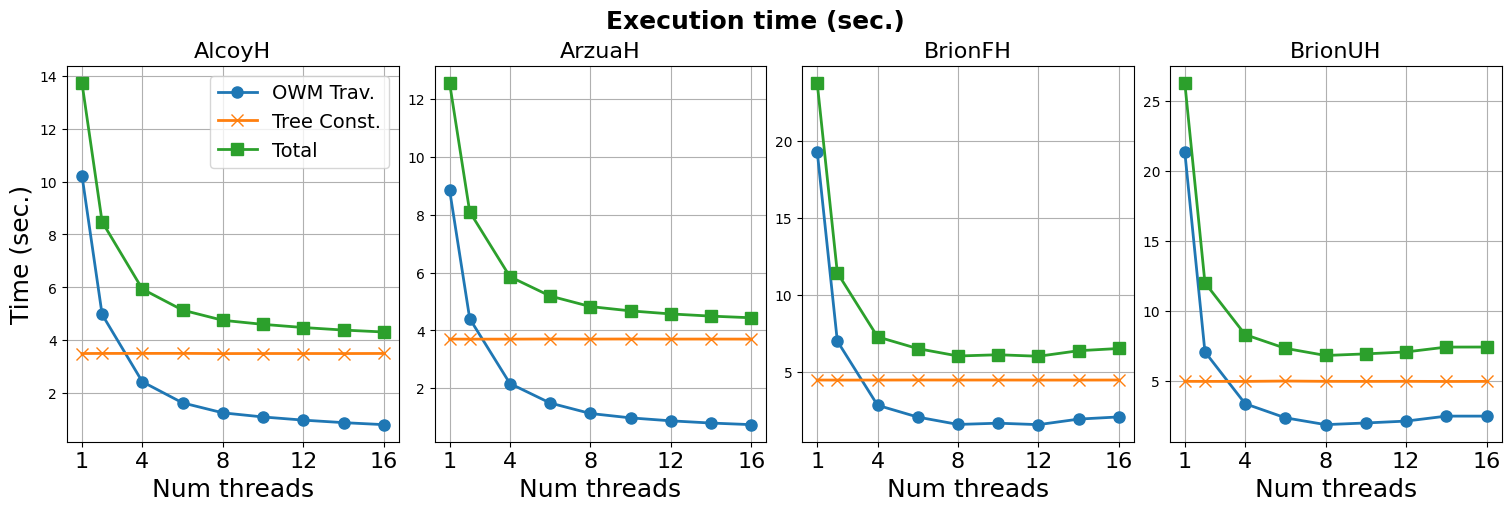

In [9]:
def plot_alltimes(results):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    labels=['OWM Trav.','Tree Const.','Total']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4), cloud_list):
        x=list(results[name].keys())
        axs[i].plot(np.array(x), np.array([results[name][nth]['owm'] for nth in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][nth]['qtree'] for nth in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][nth]['qtree']+results[name][nth]['owm'] for nth in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Num threads', fontsize=xlabelfs)
        axs[i].set_xticks(x[::2])
        axs[i].tick_params(axis='x', labelsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle('Execution time (sec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()

plot_alltimes(res1)


Phase: qtree speedup for each cloud and best level for each cloud: ['AlcoyH', 'ArzuaH', 'BrionFH', 'BrionUH']
[ 1.          1.92657195  3.64304709  5.15459401  6.73738256  7.77819396
  8.73141785  9.6061167  10.36407119]
[ 1.          1.95867122  3.80306919  5.56247173  7.12443733  8.39364499
  9.50093322 10.26644729 11.32647668]
[ 1.          1.92777182  3.72095887  5.35512272  6.97476488  8.07972577
  8.88174254  9.68474787 10.61670881]
[ 1.          1.9315958   3.70233932  5.36826392  6.90767265  8.10058008
  8.89322045  9.70892271 10.6195678 ]
Phase: owm speedup for each cloud and best level for each cloud: ['AlcoyH', 'ArzuaH', 'BrionFH', 'BrionUH']
[ 1.          1.93951651  3.73887478  5.36955184  6.88217207  7.83068437
  8.70554936  9.47235214 10.11721076]
[ 1.          1.943964    3.8014837   5.54210406  7.04814156  7.97679158
  8.73832328  9.4862662  10.06914574]
[1.         1.35440698 2.12472907 2.99192723 3.870018   4.23294897
 4.41026137 4.30724368 4.06707272]
[1.         1.

<Figure size 640x480 with 0 Axes>

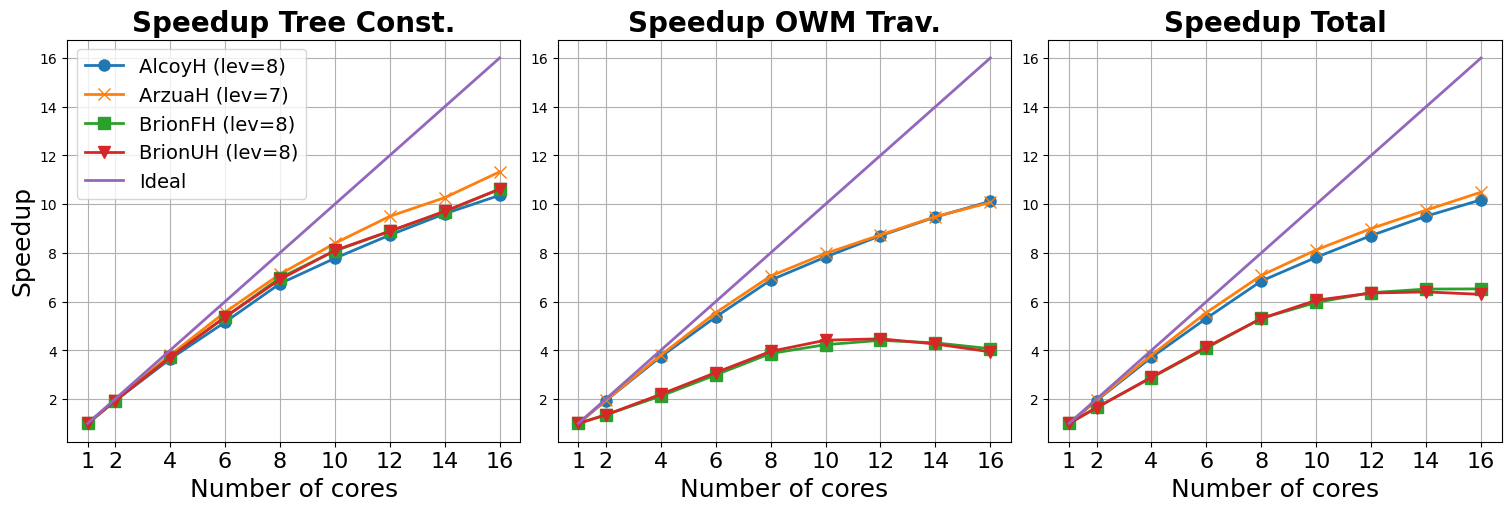

In [10]:
#Configuration variables
def plot_res(res, maxth=8):
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8

    fig = plt.figure()

    marks=['o-','x-','s-','v-','+-']
    bestlevel=[get_best_level2(res[i], maxth, 'total') for i in res]
    numthreads=list(res[cloud_list[0]][bestlevel[0]].keys())
    labels=['Tree Const.','OWM Trav.','Total']

    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15, 5), constrained_layout=True)
    sizes=[i+" (lev="+str(j)+")" for i,j in zip(res,bestlevel)]
    sizes.append('Ideal')

    for phase,subfig in zip(['qtree','owm','total'],range(3)):
        print("Phase: "+phase+ " speedup for each cloud and best level for each cloud: "+str(list(res.keys())))
        for (i,z,lev) in zip(res,marks,bestlevel):
            print(np.array([res[i][lev][1][phase]/res[i][lev][j][phase] for j in numthreads]))
            axs[subfig].plot(np.array(numthreads), np.array([res[i][lev][1][phase]/res[i][lev][j][phase] for j in numthreads]), z, linewidth=linew, markersize=markers)
        axs[subfig].plot(np.array(numthreads), np.array(numthreads), '-', linewidth=linew, markersize=markers)
        axs[subfig].set_title('Speedup '+labels[subfig],  fontweight='bold', fontsize=titlefs)
        axs[subfig].set_xlabel('Number of cores', fontsize=xlabelfs)
        axs[subfig].set_xticks(numthreads)
        axs[subfig].tick_params(axis='x', labelsize=xticksfs)
        axs[subfig].grid()

    axs[0].set_ylabel('Speedup', fontsize=ylabelfs)
    axs[0].legend(sizes,loc='best', fontsize= legendfs)
#    plt.yticks(fontsize=yticksfs)

    plt.show()
    return fig

fig = plot_res(res2, num_threads[-1])

In [ ]:
pp = PdfPages(os.path.join(hostname, f'Speedup-o2-partree-{hostname}.pdf'))
pp.savefig(fig)
pp.close()

# Save data to All_Optimizations.csv

In [ ]:
output = os.path.join(hostname, f'All_Optimizations-{hostname}.csv')

f = open(output, "a")
# select the max number of threads
maxth = num_threads[-1]
for i in :
    bestlevel=min([i], key=lambda x: [i][x][maxth]['total'])
    print("Opt2-Par; {}; {:.5f}; {:.5f};{};{}".format(i,[i][bestlevel][maxth]['qtree'],[i][bestlevel][maxth]['owm'],bestlevel,0))
    f.write("Opt2-Par;{};{:.5f};{:.5f};{};{}\n".format(i,[i][bestlevel][maxth]['qtree'],[i][bestlevel][maxth]['owm'],bestlevel,0))

f.close()